In [2]:
import wntr
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

In [3]:
cmap=matplotlib.colormaps['viridis']

In [4]:
inp_file='Net3.inp'

In [5]:
wn=wntr.network.WaterNetworkModel(inp_file)
population=wntr.metrics.population(wn)

In [6]:
start_time=2*3600
break_duration=12*3600
total_duration=start_time+break_duration
minimum_pressure=3.52
required_pressure=14.06

In [7]:
AED=wntr.metrics.average_expected_demand(wn)
nzd_junction=AED[AED>0].index
wn.options.hydraulic.demand_model='PDD'
wn.options.time.duration=total_duration
wn.options.hydraulic.minimum_pressure=minimum_pressure
wn.options.hydraulic.required_pressure=required_pressure
sim=wntr.sim.WNTRSimulator(wn)
results=sim.run_sim()
pressure=results.node['pressure'].loc[start_time::,nzd_junction]
normal_pressure_below_pmin=pressure.columns[(pressure<minimum_pressure).any()]

In [8]:
help(wntr.network.generate_valve_layer)

Help on function generate_valve_layer in module wntr.network.layer:

generate_valve_layer(wn, placement_type='strategic', n=1, seed=None)
    Generate valve layer data, which can be used in valve segmentation analysis.
    
    Parameters
    -----------
    wn : wntr WaterNetworkModel
        A WaterNetworkModel object
        
    placement_type : string
        Options include 'strategic' and 'random'.  
        
        - If 'strategic', n is the number of pipes from each node that do not 
          contain a valve. In this case, n is generally 0, 1 or 2 
          (i.e. N, N-1, N-2 valve placement).
        - If 'random', then n randomly placed valves are used to define the 
          valve layer.
        
    n : int
        
        - If 'strategic', n is the number of pipes from each node that do not 
          contain a valve.
        - If 'random', n is the number of number of randomly placed valves.
        
    seed : int or None
        Random seed
       
    Returns
    

In [9]:
valve_layer=wntr.network.generate_valve_layer(wn,placement_type='strategic',n=2,seed=123)
G=wn.to_graph()
node_segments,link_segments,segment_size=wntr.metrics.valve_segments(G,valve_layer)

/home/wahab901278/anaconda3/lib/python3.11/site-packages/wntr/metrics/topographic.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valved_link_names.append(row[0])
/home/wahab901278/anaconda3/lib/python3.11/site-packages/wntr/metrics/topographic.py:274: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valved_node_name = link_valves.iloc[0][1]


<Axes: >

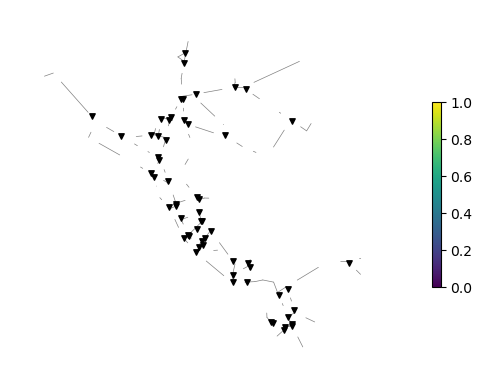

In [10]:
wntr.graphics.plot_valve_layer(wn,valve_layer,include_network=True)

AttributeError: 'list' object has no attribute 'get_array'

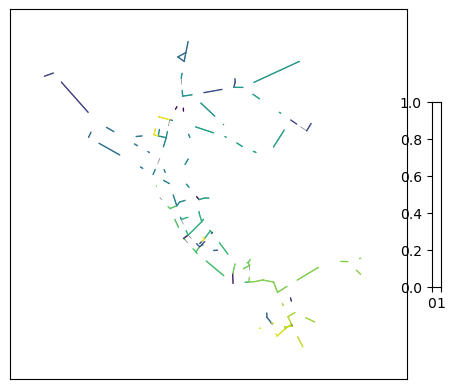

In [11]:
wntr.graphics.plot_network(wn,link_attribute=link_segments,link_cmap=cmap,node_size=0)

In [12]:

analysis_results={}
for segment in link_segments.unique():
    wn=wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model='PDD'
    wn.options.time.duration=total_duration
    wn.options.hydraulic.minimum_pressure=minimum_pressure
    wn.options.hydraulic.required_pressure=required_pressure

    pipes_in_seg=link_segments[link_segments==segment]
    for pipe_name in pipes_in_seg.index:
        pipe=wn.get_link(pipe_name)
        action=wntr.network.controls.ControlAction(pipe,'status',0)
        condition=wntr.network.controls.SimTimeCondition(wn,'Above',start_time)
        ctrl=wntr.network.controls.Control(condition,action)
        wn.add_control('close pipe'+pipe_name,ctrl)
    try:
        sim=wntr.sim.WNTRSimulator(wn)
        sim_results=sim.run_sim()
        sim_pressure=sim_results.node['pressure'].loc[start_time::,nzd_junction]
        sim_pressure_below_pmin=sim_pressure.columns[(pressure<minimum_pressure).any()]

        impacted_junctions=set(sim_pressure_below_pmin)-set(normal_pressure_below_pmin)
        impacted_junctions=list(impacted_junctions)
    except Exception as e:
        impacted_junctions=None
        print(segment,'Failed',e)
    finally:
        analysis_results[segment]=impacted_junctions
        

In [13]:
num_junctions_impacted_per_segment={}
num_people_impacted_per_segment={}
for segment,impacted_juction in analysis_results.items():
    if impacted_juction is not None:
        num_junctions_impacted_per_segment[segment]= len(impacted_juction)
        num_people_impacted_per_segment[segment]=population[impacted_juction].sum()

num_junctions_impacted=link_segments.map(num_junctions_impacted_per_segment)
num_people_impacted=link_segments.map(num_people_impacted_per_segment)


In [14]:
num_junctions_impacted=pd.Series(num_junctions_impacted)

AttributeError: 'list' object has no attribute 'get_array'

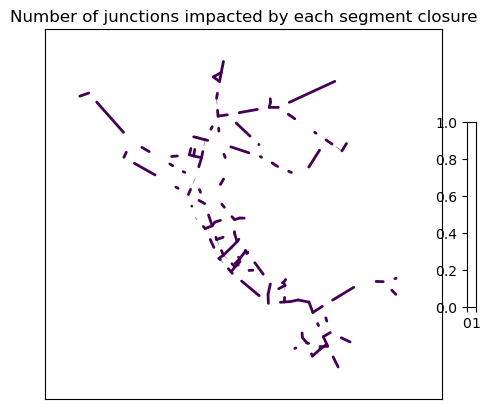

In [15]:
num_junctions_impacted = pd.Series(num_junctions_impacted)

# Plot junctions impacted due to segment breaks
wntr.graphics.plot_network(wn, link_attribute=num_junctions_impacted, node_size=0, link_width=2, 
                           link_range=[0,10], link_cmap=cmap, link_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each segment closure')

# Extract current axes
ax = plt.gca()

# Graph valve layer onto the same axes
wntr.graphics.plot_valve_layer(wn, valve_layer, add_colorbar=False, include_network=False, ax=ax)
plt.show()